# Description

Recently, I run into the concept of Bayesian Inference. It seems very intuitive and able to describe the thing in probabilistic way.  
Also, I am curios about what is the difference between Bayesian Inference approach vs Frequentist approach  
So, here we will use both approaches to model ROI of marketing campaigns, and then make decision on how to allocate the budget to maximize the ROI.

## Related Resources
https://medium.com/@andreasherman/get-started-with-bayesian-inference-cec9ad4ccd55  
https://github.com/markdregan/Bayesian-Modelling-in-Python  
https://towardsdatascience.com/a-b-testing-with-probabilistic-programming-and-pymc3-part-i-7ae52d45bc41

# Objective
1. What is Bayesian Inference
2. Use Case of Bayesian Inference with MCMC 
3. What is Frequentist Approach and Hypothesis Test 
4. What is the difference between Bayesian Inference and Hypothesis Test
5. Decision making based of Bayesian Framework

# Baysian Inference and MCMC

Bayesian inference is a probabilistic programming approach which incorporating prior knowledge into our analysis to quantify uncertainty about parameters and models by using Bayes’ Theorem

## Let’s quickly revise Bayes’ Theorem
```
Bayes’ Theorem: P(θ|D) = P(D|θ)P(θ) / P(D)
```

θ is a parameter in our probabilistic model and D our data. We are calculating the posterior distribution P(θ|D) - the probability of how plausible different parameter values are, given the data, based on:
Likelihood P(D|θ): the probability of observing the data, given the parameter θ taking different values. This is what we usually maximize in traditional Frequentist Machine Learning (recall MLE).

Prior P(θ): the probability of θ taking different values based on what we know about the parameter before seeing the data. It can for instance be non-informative (flat - every value is equally likely), weakly informative (regularization - guarding against extreme associations between variables), subjective (personal beliefs in some values being more plausible). The prior can also simply be the posterior from another problem (or the same problem but now we just have new observations). 

Evidence P(D): the probability of observing the data we have. This is also referred to as marginal likelihood or average likelihood. It is the average probability of the data given all possible values θ can take.
When we are doing inference, we often care only about the relative values of the parameters. In this sense we can omit the marginal likelihood and see the posterior as being proportional: P(θ|D)∝P(D|θ)P(θ). This is enough to select values of θ and understand the posterior’s shape, since P(D) is constant for the same model.

## MCMC
How do we get the posterior?
In order to obtain the posterior distribution we need to calculate the product of the prior and likelihood. This seems easy! However, it can be quite cumbersome for many dimensions and large spaces. We can instead try to approximate it. MCMC is a family of methods used to do this (there are other ways too). MCMC basically searches the posterior space and returns samples as a way of mapping out the surface of the distribution (this can still sometimes be quite heavy, but is becoming more feasible as computational resources become more available along with advancements in ways of approximating the posterior).  

In some cases, we can actually calculate the posterior analytically. Conjugate priors make it possible to do so. This only applies to certain cases. For many years, Bayesian analysis was restricted to use conjugate priors; now with modern computational methods we can solve Bayesian problems whether we use conjugate priors or not. We can kind of specify any probabilistic monster model and do not have to bother about it being analytically derivable. The sampler takes care of it!

# Marketing Campaign Performance

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm
import itertools
import seaborn as sns

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

Here, we import a sample of campaign performance report   
The table tells about which `advertising platform` a lead coming from, and their respective performance  

Each row of the table represents a signup lead(`Binary User ID`), and his respective cost of acquisition (advertising `spend`)

`will_deposit` column is coming from the prediction model on whether a particular lead will deposit  
`predicted_clv_90` colummn represents the expected deposit amount within 90 days of signup (if he/she really deposit), for simplicity, we assume that deposit amount = revenue.
Then, here we represent `will_deposit*predicted_clv_90` as an approximation of the `campaign revenue` so that we can already tell the performance much earlier, instead of waiting for months of tail performance. (Time is gold)

In marketing funnel, there are a lot of stages (conversions)  
From `Stranger to Visitor to Lead to Activated Client to Revenue`    
But here we will just simplify it into 3 stages.  
Spend > Leads Count > Deposited Leads Count > Total Revenue

In [4]:
"""
SELECT binary_user_id,platform,cost as spend,predicted_clv_30,predicted_clv_90,will_deposit
FROM `business-intelligence-240201.ppc_model.ppc_lead_with_score_clv_predicted_clv` 
where expense_week >= '2021-04-01' and expense_week < '2021-05-01'
"""
performance = pd.read_csv('campaign_performance.csv')
performance['predicted_clv_90_deposited'] = performance['predicted_clv_90']*performance['will_deposit']

In [5]:
platform_performance = performance.groupby(['platform']).agg({'spend':'sum','binary_user_id':'count','will_deposit':'sum','predicted_clv_90':'sum','predicted_clv_90_deposited':'sum'}).reset_index()
platform_performance.columns = ['platform','spend','lead_count','pred_deposited_lead','pred_clv_90','pred_clv_90_deposited']
platform_performance['spend_to_lead_conversion'] = platform_performance['lead_count']/platform_performance['spend']
#create an array of platforms for future use
platforms = platform_performance['platform'].unique()

In [6]:
platform_performance.head()

,platform,spend,lead_count,pred_deposited_lead,pred_clv_90,pred_clv_90_deposited,spend_to_lead_conversion
0,adroll,740.526238,94,1,10348.887952,67.840000,0.126937
1,bing,8826.390000,159,10,14742.225510,830.218717,0.018014
2,fb,376.993800,99,1,9125.705203,68.000000,0.262604
3,google,1292.470000,43,3,3967.682962,248.663000,0.033270
4,match2one,5127.800000,124,3,13586.944053,285.023449,0.024182


## Spend to Lead conversion

In industry, we usually use `cost per lead` (cpl) to tell how much we have to spend for 1 lead (signup lead) where  
```
CPL = Spend / Lead Count
```
However, we can change it into a conversion which is more easy to model by using 1/CPL as it is bounded by \[0,1\], which 
```
Spend_to_Lead_Conversion = Lead Count / Spend
```  


First, we try with only 1 platform-`adroll`

In [7]:
adroll_performance = platform_performance.iloc[0,]
adroll_performance

platform                      adroll
spend                        740.526
lead_count                        94
pred_deposited_lead                1
pred_clv_90                  10348.9
pred_clv_90_deposited          67.84
spend_to_lead_conversion    0.126937
Name: 0, dtype: object

/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  from ipykernel import kernelapp as app
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p]
>Metropolis: [y_pred]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


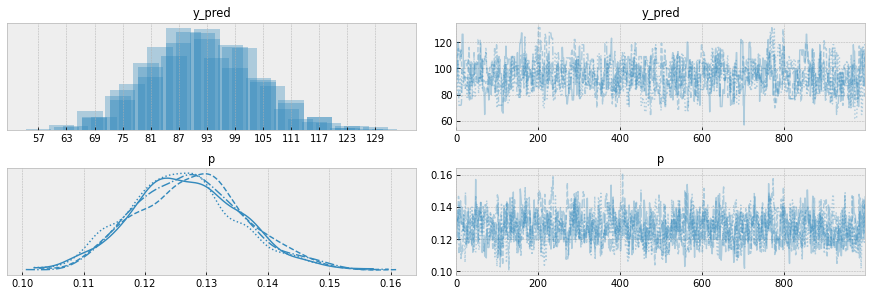

In [8]:
#we use binomial for likelihood
#for binomial parameters ~B(n,p)
#we use beta distribution for prior of p, where alpha = number of successes(lead_count),beta = n - number of successes
#we use spend_amount as n
with pm.Model() as binomial_model:
    
    n = adroll_performance['spend']
    a = adroll_performance['lead_count']
    b = n-a
    p = pm.Beta('p',alpha=a,beta=b)
    likelihood = pm.Binomial('likelihood', n = n, p = p, observed=a)
    y_pred = pm.Binomial('y_pred',n = n, p = p)
    #step = pm.Metropolis()
    #trace = pm.sample(200000, step, start=start, progressbar=True)
    trace = pm.sample(1000, progressbar=True)
    pm.plot_trace(trace)

<AxesSubplot:title={'center':'x\n0'}>

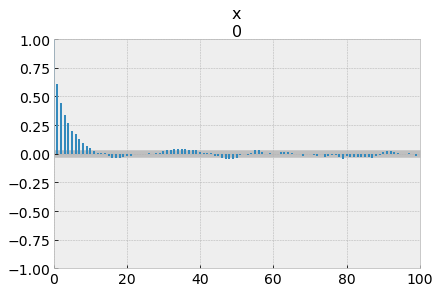

In [9]:
pm.plot_autocorr(trace.get_values('p'))

### Model Convergence

#### Trace
Just because the above model estimated a value for μ, doesn't mean the model estimated a good value given the data. There are some recommended checks. Firstly, look at the trace output. You should see the trace jumping around and generally looking like a hairy caterpillar. If you see the trace snake up and down or appear to be stuck in any one location - it is a sign that you have convergence issues and the estimations from the MCMC sampler cannot be trusted.

#### Autocorrelation plot
The second test you can perform is the autocorrelation test (see below plot). It is a measure of correlation between successive samples in the MCMC sampling chain. When samples have low correlation with each other, they are adding more "information" to the estimate of your parameter value than samples that are highly correlated.

Visually, you are looking for an autocorrelation plot that tapers off to zero relatively quickly and then oscilates above and below zero correlation. If your autocorrelation plot does not taper off - it is generally a sign of poor mixing and you should revisit your model selection (eg. likelihood) and sampling methods (eg. Metropolis).

__The model convergence looks fine from both trace and autocorrelation plots__

### Experiment with higher n
Higher n give narrower posterior, which means we are more confident on the posterior  
Above we see most of the density are between 0.11-0.14  
Below(with 10 times more n), most of the density are between 0.1225-0.1325

/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p]
>Metropolis: [y_pred]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


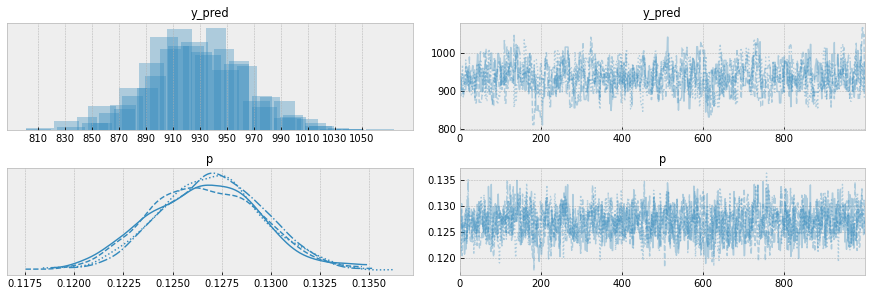

In [10]:
#higher n give narrower posterior, we are more confident
with pm.Model() as binomial_model:
    
    n = adroll_performance['spend'] * 10
    a = adroll_performance['lead_count'] * 10
    b = n-a
    p = pm.Beta('p',alpha=a,beta=b)
    likelihood = pm.Binomial('likelihood', n = n, p = p, observed=a)
    y_pred = pm.Binomial('y_pred',n = n, p = p)
    #step = pm.Metropolis()
    #trace = pm.sample(200000, step, start=start, progressbar=True)
    trace = pm.sample(1000, progressbar=True)
    pm.plot_trace(trace)

### Experiment with low conversion
We still have some distribution on posterior p even though we only get 1 conversion

/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p]
>Metropolis: [y_pred]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


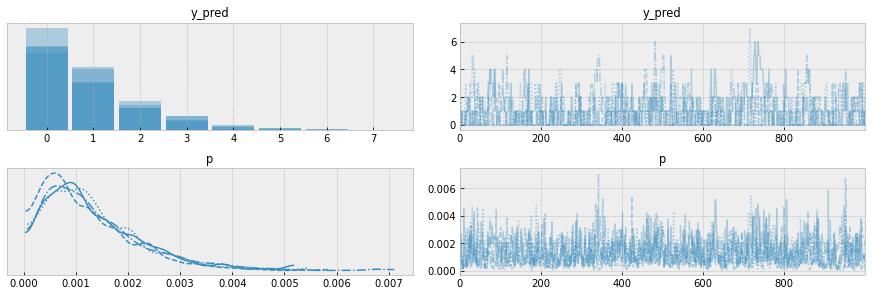

In [29]:
with pm.Model() as binomial_model:
    
    n = 740
    a = 1
    b = n-a
    p = pm.Beta('p',alpha=a,beta=b)
    likelihood = pm.Binomial('likelihood', n = n, p = p, observed=a)
    y_pred = pm.Binomial('y_pred',n = n, p = p)
    #step = pm.Metropolis()
    #trace = pm.sample(200000, step, start=start, progressbar=True)
    trace = pm.sample(1000, progressbar=True)
    pm.plot_trace(trace)

## Compare Performance Between Platform
We want to know what is the posterior distribution of p for each platforms  
Also, We want to know which platform is performing better

In [11]:
indiv_traces = {}
platforms = platform_performance['platform'].unique()
for platform in platforms:
    with pm.Model() as model:
        
        n = platform_performance.loc[platform_performance['platform']==platform]['spend'].values[0]
        a = platform_performance.loc[platform_performance['platform']==platform]['lead_count'].values[0]
        b = n-a
        p = pm.Beta('p',alpha=a,beta=b)
        likelihood = pm.Binomial('likelihood', n=n, p=p,observed= a)
        trace = pm.sample(1000, progressbar=True)   
        indiv_traces[platform] = trace

/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8797186484956567, but should be close to 0.8. Try to increase the number of tuning steps.
/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8794610527634266, but should be close to 0.8. Try to increase the number of tuning steps.
/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


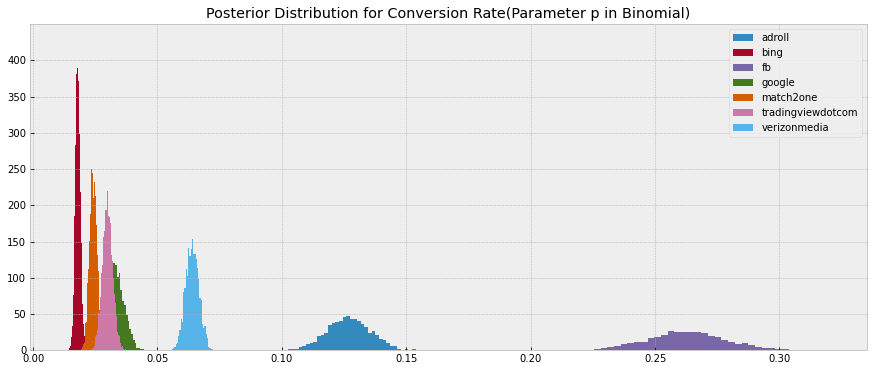

In [12]:
plt.figure(figsize = (15, 6))
for p in platforms:
    samples_posterior = indiv_traces[p].get_values('p')
    plt.hist(samples_posterior, bins=40, label=p , density=True)
plt.title('Posterior Distribution for Conversion Rate(Parameter p in Binomial)')
plt.legend()
plt.show()

`google` and `tradingviewdotcom` overlap a lot, so we want to see what is the probability of one is better than another

In [13]:
def prob_better(platforma, platformb):
    return np.float(np.sum(indiv_traces[platforma].get_values('p') > indiv_traces[platformb].get_values('p'))/len(indiv_traces[platforma].get_values('p')))

In [14]:
platforma = 'google'
platformb = 'tradingviewdotcom'
print("Probability that ", platforma," is better faster than ", platformb," is {:.2%}".format(prob_better(platforma, platformb)))

Probability that  google  is better faster than  tradingviewdotcom  is 79.22%


Compute again with 2 distribution that is furthest apart, `bing` , `fb`

In [15]:
platforma = 'bing'
platformb = 'fb'
print("Probability that ", platforma," is better faster than ", platforma," is {:.2%}".format(prob_better(platforma, platformb)))

Probability that  bing  is better faster than  bing  is 0.00%


Now, lets create heatmap for pairwise comparison

In [16]:
# Create an empty dataframe
ab_dist_df = pd.DataFrame(index=platforms, columns=platforms, dtype=np.float)

# populate each cell in dataframe with persona_less_personb()
for a, b in itertools.permutations(platforms, 2):
    ab_dist_df.loc[a, b] = prob_better(a, b)
    
# populate the diagonal
for a in platforms:
    ab_dist_df.loc[a, a] = 0.5

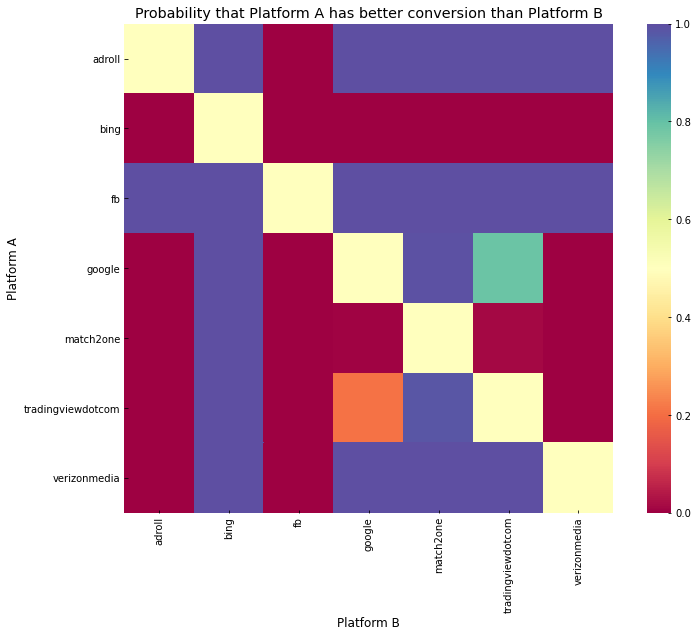

In [17]:
# Plot heatmap
f, ax = plt.subplots(figsize=(12, 9))
cmap = plt.get_cmap("Spectral")
_ = sns.heatmap(ab_dist_df, square=True, cmap=cmap)
_ = plt.title('Probability that Platform A has better conversion than Platform B')
_ = plt.ylabel('Platform A')
_ = plt.xlabel('Platform B')

# Frequentist Hypothesis Test

## Central Limit Theorem
Central Limit Theorem states that if we get enough sample size, and run it multiple time. The distribution of the sampling mean will approach a normal distribution  
Here we will proof by drawing N(10,20,50,100) samples from lognormal (skewed distribution) for 1000 and see what's the sampling mean distribution.  
We can see that as `n` getting larger, the distribution is more normal-like

In [25]:
def test_CLT(sample_n):
    x_bars=np.zeros(1000)
    for i in range(1000):
        x = np.zeros(sample_n)
        for j in range(sample_n):
                x[j] = np.random.lognormal(0,1, size=None)
        x_bar = x.mean()
        x_bars[i] = x_bar
    return x_bars

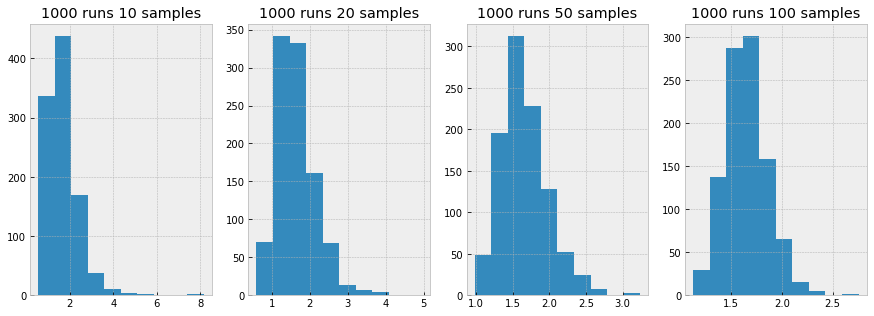

In [26]:
fig, ax = plt.subplots(1,4,figsize=(15,5))
for i,n in enumerate([10,20,50,100]):
    ax[i].hist(test_CLT(n))
    ax[i].set_title('1000 runs '+str(n) +' samples')

## Z-Test For Proportion Difference
Classic hypothesis test is approachable because of central limit theorem. Because we can then estimate the distance between the sample mean with the `null hypotheis mean`, and check? the probability of observing the data assuming that `null hpoyhesis` is true (p-value).  
A standard z_score calculation will be (x_bar - x(h0)) / (std_deviation/sqrt(n))  
More Info: https://towardsdatascience.com/the-art-of-a-b-testing-5a10c9bb70a4

In [18]:
platform_performance

,platform,spend,lead_count,pred_deposited_lead,pred_clv_90,pred_clv_90_deposited,spend_to_lead_conversion
0,adroll,740.526238,94,1,10348.887952,67.840000,0.126937
1,bing,8826.390000,159,10,14742.225510,830.218717,0.018014
2,fb,376.993800,99,1,9125.705203,68.000000,0.262604
3,google,1292.470000,43,3,3967.682962,248.663000,0.033270
4,match2one,5127.800000,124,3,13586.944053,285.023449,0.024182
5,tradingviewdotcom,3340.093846,100,4,11360.389441,454.010000,0.029939
6,verizonmedia,4090.648413,262,20,28435.144509,1982.810000,0.064049


In [19]:
#https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
from statsmodels.stats.proportion import proportions_ztest

In [20]:
#as proportions_ztest in statsmodel doesnt take care of left tail or right tail, so we use 1-pval for z_score is negative given alternative is 'larger'
def proportion_diff_z_test_a_grater_than_b(df_performance,platforma,platformb,alternative='larger'):
    platform_performance.set_index('platform',inplace=True,drop=False)
    count = platform_performance.loc[[platforma,platformb],'lead_count'].values
    nobs = platform_performance.loc[[platforma,platformb],'spend'].values
    proportions_ztest(count=count, nobs=nobs,value=0, alternative=alternative,prop_var=False)
    stat, pval = proportions_ztest(count, nobs)
    if alternative  == 'larger' and stat <0:
        pval = 1 - pval
    return pval
    #print('Platform A:{}'.format(platforma))
    #print('Platform B:{}'.format(platformb))
    #print('H0: proportion a - proportion b = 0')
    #print('H1: proportion a - proportion b {} 0'.format(alternative))
    #print('z-score: {0:0.3f}'.format(stat))
    #print('p-value: {0:0.3f}'.format(pval))

In [21]:
# Create an empty dataframe
ab_ztest_df = pd.DataFrame(index=platforms, columns=platforms, dtype=np.float)

# populate each cell in dataframe with proportion difference z test
for a, b in itertools.permutations(platforms, 2):
    ab_ztest_df.loc[a, b] = proportion_diff_z_test_a_grater_than_b(platform_performance,a, b)
    
# populate the diagonal
for a in platforms:
    ab_ztest_df.loc[a, a] = 0.5

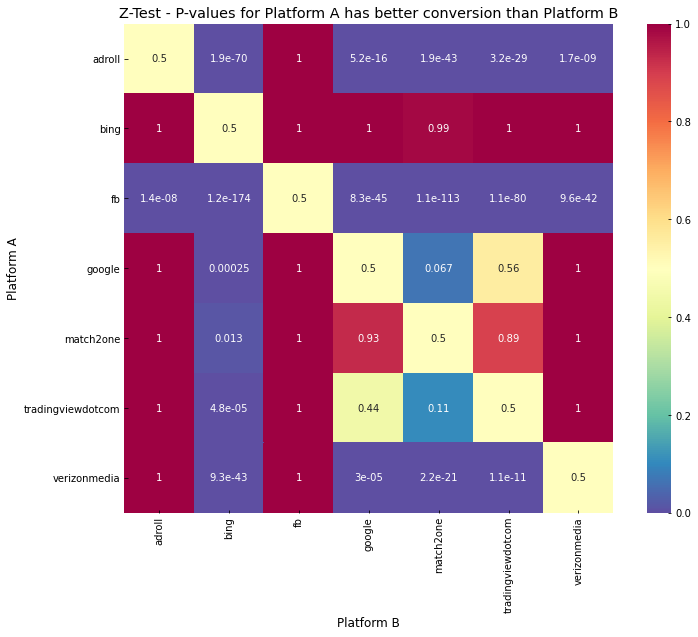

In [23]:
# Plot heatmap
# here i do reverse cmap to match the colour for bayesian approach. As lowwe p-value(frequentist) refers to higher prob of difference(bayesian)
f, ax = plt.subplots(figsize=(12, 9))
cmap = plt.get_cmap("Spectral_r")
_ = sns.heatmap(ab_ztest_df, square=True, cmap=cmap, annot = True)
_ = plt.title('Z-Test - P-values for Platform A has better conversion than Platform B')
_ = plt.ylabel('Platform A')
_ = plt.xlabel('Platform B')

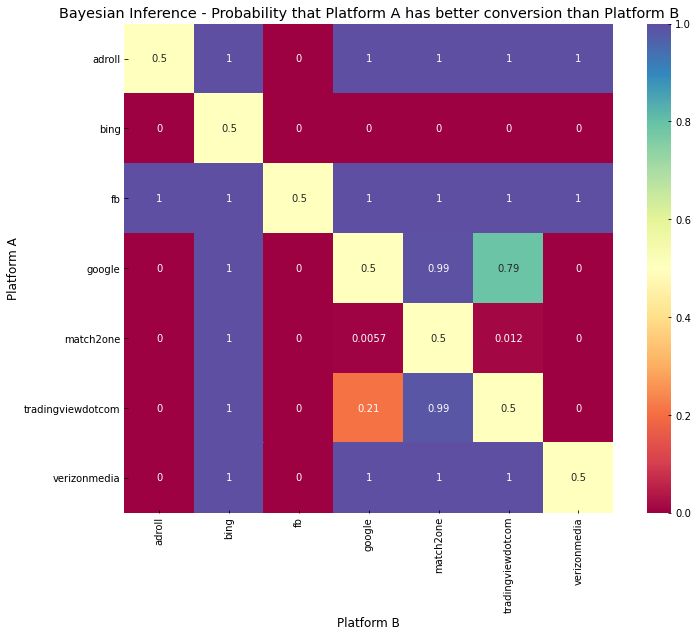

In [24]:
#show bayesian comparison again to compare both approach
# Plot heatmap
f, ax = plt.subplots(figsize=(12, 9))
cmap = plt.get_cmap("Spectral")
_ = sns.heatmap(ab_dist_df, square=True, cmap=cmap, annot = True)
_ = plt.title('Bayesian Inference - Probability that Platform A has better conversion than Platform B')
_ = plt.ylabel('Platform A')
_ = plt.xlabel('Platform B')

# Comparing Both Approach

According to this article https://towardsdatascience.com/a-b-testing-with-probabilistic-programming-and-pymc3-part-i-7ae52d45bc41  
There are some drawbacks about classic hypothesis test. Some of them are:
1. It does not provide full information about the difference between the two means. In particular, it does not really provide a certain level of confidence in our final decision.
2. It requires us to fix a sample size beforehand.
3. The traditional t-test uses p-values to accept/reject the null hypothesis. From my conversations with my mentor at Kibo Commerce, Austin Rochford, I learned that marketers often misinterpret p-values as the probability that the experiment group performs better than the control group. This misunderstanding could lead to poor business decisions.
4. It is not easy to use to t-test to answer more complicated questions such as quantifications of the difference. For example, sometimes we are not just interested in whether the experiment group performs better than the control group but also how much better. This is important because it often costs resources such as time and money to implement a new strategy; so we have to be strategic to decide whether it is worth doing so.


## Results Comparison
Basically both apporaches show similar results. Except slightly difference of confidence level for google, matchone, and tradingviewdotcom comparison  
There is one advantage with Bayesian Approach.  
With Bayesian, we can actually tell what's the probability of A is better than B.
However, we cannot do so with classic hypothesis testing. The p-value actually tells us the probability of seeing the data assuming the conversion rates are the same. It only gives us the confidence to reject HO.  
So for such comparision, I will prefer to use Bayesian Apporach

# Test Multi Conversion

In [133]:
platform_performance

,platform,spend,lead_count,pred_deposited_lead,pred_clv_90,pred_clv_90_deposited,spend_to_lead_conversion
0,adroll,740.526238,94,1,10348.887952,67.840000,0.126937
1,bing,8826.390000,159,10,14742.225510,830.218717,0.018014
2,fb,376.993800,99,1,9125.705203,68.000000,0.262604
3,google,1292.470000,43,3,3967.682962,248.663000,0.033270
4,match2one,5127.800000,124,3,13586.944053,285.023449,0.024182
5,tradingviewdotcom,3340.093846,100,4,11360.389441,454.010000,0.029939
6,verizonmedia,4090.648413,262,20,28435.144509,1982.810000,0.064049


/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


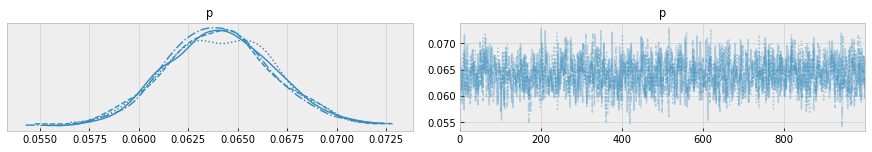

In [163]:
#higher n give narrower posterior, we are more confident
with pm.Model() as binomial_model:
    
    n = 4090
    a = 262
    b = n-a
    p = pm.Beta('p',alpha=a,beta=b)
    likelihood = pm.Binomial('likelihood', n = n, p = p, observed=a)
    #y_pred = pm.Binomial('y_pred',n = n, p = p)
    #step = pm.Metropolis()
    #trace = pm.sample(200000, step, start=start, progressbar=True)
    spend_to_lead_trace = pm.sample(1000, progressbar=True)
    pm.plot_trace(spend_to_lead_trace) 

/Applications/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8816114429030476, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88169190733549, but should be close to 0.8. Try to increase the number of tuning steps.


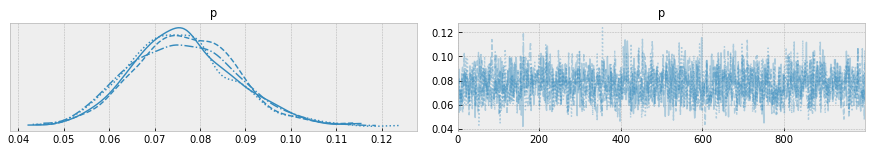

In [164]:
#higher n give narrower posterior, we are more confident
with pm.Model() as binomial_model:
    
    n = 262
    a = 20
    b = n-a
    p = pm.Beta('p',alpha=a,beta=b)
    likelihood = pm.Binomial('likelihood', n = n, p = p, observed=a)
    #y_pred = pm.Binomial('y_pred',n = n, p = p)
    #step = pm.Metropolis()
    #trace = pm.sample(200000, step, start=start, progressbar=True)
    lead_to_deposit_trace = pm.sample(1000, progressbar=True)
    pm.plot_trace(lead_to_deposit_trace) 

In [167]:
multiple_conv = 4090*spend_to_lead_trace.get_values('p') * lead_to_deposit_trace.get_values('p')

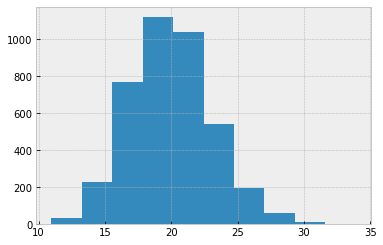

In [168]:
plt.hist(multiple_conv);

# Next steps

1. Try to model all stages of conversion (ie:spend to lead, lead to deposited lead, deposited lead to deposit amount), then compute the ROI distribution, and compare the performance between platforms again. Is the performance ranking different now?
2. Try with hierachical model with partial pooling. We can include data about country, and do pooling within country as we expect similar performance within country  
https://www.smartly.io/blog/tutorial-how-we-productized-bayesian-revenue-estimation-with-stan  
https://twiecki.io/blog/2014/03/17/bayesian-glms-3/  
https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/